# Estimate head motion for each subject

Use root-mean-square: prefiltered_func_data_mcf_rel_mean.rms gives the values between one image and the next image in the series. Mean Motion represents the mean absolute displacement of each brain volume as relative to the previous volume. The mean and maximum displacements in 3D space for each brain volume were computed as the root-mean-square (RMS) of the translation parameters (displacement = square root (x2 + y2 + z2)) and expressed in mm. 

Another measure, Number of Movements, was estimated as the number of relative displacements > 0.1 mm in 3D space between adjacent volumes. Thus, the metric is expressed as an integer with the minimum possible value being 0 and the maximum n-1 where n is the number of acquired volumes in the study. 

In [1]:
import os
import csv
import pandas as pd

In [2]:
os.chdir('/project/3013104.01/')
os.getcwd()

'/project/3013104.01'

## Concatenate .rms files across all subjects and sessions

Use the file 'prefiltered_func_data_mcf_rel_mean.rms' in each subject-session's 'mc' dir. Each file contains 1 value in mm.

In [10]:
working_directory = 'pulled-data-MRI'
output_file = 'analysis/head_motion.csv'
tasks = ['mri_movietask_1', 'mri_movietask_2', 'mri_movietask_3']

# Function to find sub-directories starting with 'subject-*'
def find_subject_directories(directory):
    return [subdir for subdir in os.listdir(directory) if subdir.startswith('subject-') and os.path.isdir(os.path.join(directory, subdir))]

# Function to concatenate files and extract data
def process_subject_task_data(subject_directory, task):
    data = []
    file_pattern = os.path.join(working_directory, subject_directory, task, 'mc', 'prefiltered_func_data_mcf_rel_mean.rms')

    if os.path.exists(file_pattern):
        with open(file_pattern, 'r') as file:
            for line in file:
                rel_mean_rms = float(line.strip())  # Assuming the data in the file is numeric
                data.append((subject_directory, task, rel_mean_rms))
    else:
        print(f"File not found for subject: {subject_directory}, task: {task}")

    return data

all_data = []

for subject_directory in find_subject_directories(working_directory):
    for task in tasks:
        subject_task_data = process_subject_task_data(subject_directory, task)
        all_data.extend(subject_task_data)

# Write data to the output CSV file
with open(output_file, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(['subject', 'task', 'rel_mean_rms'])
    csv_writer.writerows(all_data)

print("Data processing and writing completed.")

File not found for subject: subject-0126, task: mri_movietask_1
File not found for subject: subject-0116, task: mri_movietask_1
File not found for subject: subject-0231, task: mri_movietask_3
File not found for subject: subject-0123, task: mri_movietask_2
File not found for subject: subject-0031, task: mri_movietask_1
File not found for subject: subject-0162, task: mri_movietask_1
File not found for subject: subject-0002, task: mri_movietask_2
File not found for subject: subject-0002, task: mri_movietask_3
File not found for subject: subject-0181, task: mri_movietask_1
File not found for subject: subject-0033, task: mri_movietask_2
File not found for subject: subject-0066, task: mri_movietask_2
File not found for subject: subject-0089, task: mri_movietask_1
File not found for subject: subject-0237, task: mri_movietask_2
File not found for subject: subject-0062, task: mri_movietask_2
File not found for subject: subject-0062, task: mri_movietask_3
File not found for subject: subject-0155

In [14]:
df = pd.read_csv('analysis/head_motion.csv')

# Filter rows where 'task' is 'mri_movietask_1'
filtered_df = df[df['task'] == 'mri_movietask_3']

# Calculate the mean and standard deviation of 'rel_mean_rms'
mean_rel_mean_rms = filtered_df['rel_mean_rms'].mean()
std_rel_mean_rms = filtered_df['rel_mean_rms'].std()

print(f"Mean of 'rel_mean_rms': {mean_rel_mean_rms}")
print(f"Standard deviation of 'rel_mean_rms': {std_rel_mean_rms}")

Mean of 'rel_mean_rms': 0.12027273491379312
Standard deviation of 'rel_mean_rms': 0.04544833560951867


Task: mri_movietask_1
Mean of 'rel_mean_rms': 0.12224729733333334
Standard deviation of 'rel_mean_rms': 0.052325449814512495


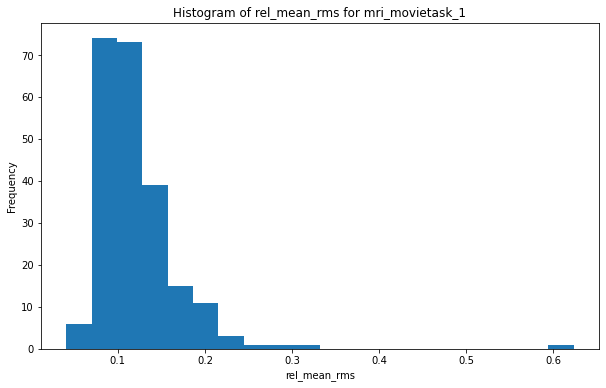

Task: mri_movietask_2
Mean of 'rel_mean_rms': 0.1200188153508772
Standard deviation of 'rel_mean_rms': 0.04583321305039493


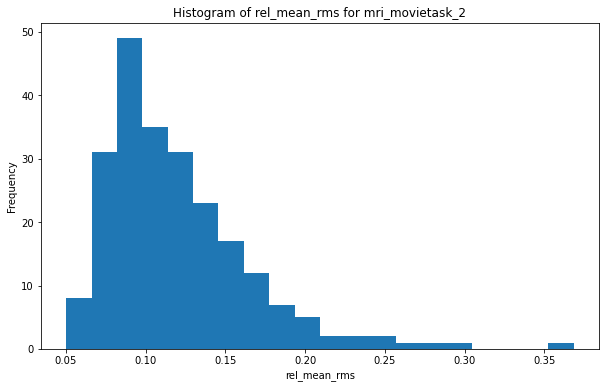

Task: mri_movietask_3
Mean of 'rel_mean_rms': 0.12027273491379308
Standard deviation of 'rel_mean_rms': 0.045448335609518664


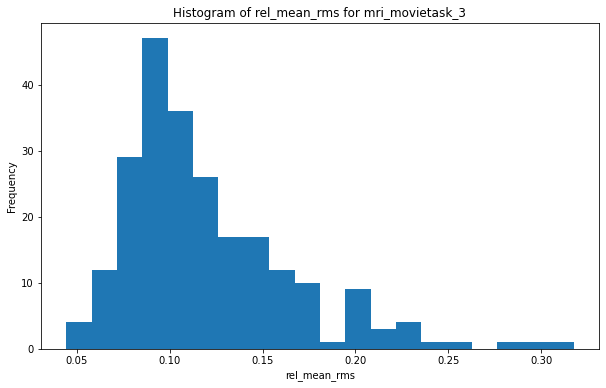

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file into a DataFrame
df = pd.read_csv('analysis/head_motion.csv')

# List of unique tasks
unique_tasks = df['task'].unique()

for task in unique_tasks:
    # Filter rows for the current task
    filtered_df = df[df['task'] == task]

    # Calculate the mean and standard deviation of 'rel_mean_rms' for the current task
    mean_rel_mean_rms = filtered_df['rel_mean_rms'].mean()
    std_rel_mean_rms = filtered_df['rel_mean_rms'].std()

    print(f"Task: {task}")
    print(f"Mean of 'rel_mean_rms': {mean_rel_mean_rms}")
    print(f"Standard deviation of 'rel_mean_rms': {std_rel_mean_rms}")

    # Create a histogram of 'rel_mean_rms' for the current task
    plt.figure(figsize=(10, 6))
    plt.hist(filtered_df['rel_mean_rms'], bins=20)
    plt.xlabel('rel_mean_rms')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of rel_mean_rms for {task}')
    plt.show()


## Assess the relationship between motion and neural data

In [15]:
import os
import pandas as pd
from scipy.stats import pearsonr

# Define the list of MRI movie tasks
mri_movietasks = ['mri_movietask_1', 'mri_movietask_2', 'mri_movietask_3']

# Output directory for saving correlation results
out_dir = 'analysis/motion'

# Create the output directory if it doesn't exist
os.makedirs(out_dir, exist_ok=True)

# Create a dictionary to store correlations for each subject and MRI movie task
correlation_results = {}

# Iterate through files in the data directory
for subject in os.listdir('analysis/roi_estimations'):
    if not subject.endswith('.csv'):
        continue
    
    # Extract the subject name from the activation data filename
    subject_name = subject.split('_')[0]
    
    # Initialize subject-specific dictionary
    if subject_name not in correlation_results:
        correlation_results[subject_name] = {mri_task: {'r': None, 'p': None} for mri_task in mri_movietasks}
    
    # Loop through MRI movie tasks
    for mri_movietask in mri_movietasks:
        # Define paths to activation and motion data files
        activation_data_path = f'analysis/roi_estimations/{subject_name}_{mri_movietask}_smoothed_filtered_func_data_clean_MNI.nii.csv'
        motion_data_path = f'pulled-data-MRI/{subject_name}/{mri_movietask}/mc/prefiltered_func_data_mcf_rel.rms'
        
        # Check if both files exist before proceeding
        if os.path.exists(activation_data_path) and os.path.exists(motion_data_path):
            # Load activation and motion data into DataFrames
            activation_df = pd.read_csv(activation_data_path, header=0)  # Assuming header is in the first row
            motion_df = pd.read_csv(motion_data_path, header=None, names=['motion_parameter'])
            
            # Remove the first row (corresponding to the first time point) from activation data
            activation_df = activation_df.iloc[1:]
            
            # Ensure that the dimensions match (number of rows)
            if activation_df.shape[0] == motion_df.shape[0]:
                # Calculate Pearson correlation and p-value between mean activation data and motion data
                corr_coefficient, p_value = pearsonr(activation_df.mean(axis=1), motion_df['motion_parameter'])
                
                # Store the correlation coefficient and p-value in the results dictionary
                correlation_results[subject_name][mri_movietask]['r'] = corr_coefficient
                correlation_results[subject_name][mri_movietask]['p'] = p_value
            else:
                print(f"Dimensions of {activation_data_path} and {motion_data_path} do not match for {subject_name} and {mri_movietask}")
        else:
            print(f"Files not found for {subject_name} and {mri_movietask}")

# Create a DataFrame with subjects, MRI tasks, correlation values, and p-values
result_data = []

for subject_name, tasks_data in correlation_results.items():
    for mri_movietask, corr_data in tasks_data.items():
        result_data.append([subject_name, mri_movietask, corr_data['r'], corr_data['p']])

result_df = pd.DataFrame(result_data, columns=['subject', 'MRI_movie_task', 'correlation_r', 'p_value'])

# Save the results to a CSV file
correlation_file = os.path.join(out_dir, 'correlation_results.csv')
result_df.to_csv(correlation_file, index=False)

print(f"Correlation results saved to {correlation_file}")


Files not found for subject-0008 and mri_movietask_2
Files not found for subject-0008 and mri_movietask_2
Files not found for subject-0016 and mri_movietask_1
Files not found for subject-0016 and mri_movietask_2
Files not found for subject-0023 and mri_movietask_2
Files not found for subject-0023 and mri_movietask_2
Files not found for subject-0027 and mri_movietask_1
Files not found for subject-0027 and mri_movietask_3
Files not found for subject-0031 and mri_movietask_1
Files not found for subject-0031 and mri_movietask_1
Files not found for subject-0033 and mri_movietask_2
Files not found for subject-0033 and mri_movietask_2
Files not found for subject-0040 and mri_movietask_2
Files not found for subject-0040 and mri_movietask_2
Files not found for subject-0041 and mri_movietask_1
Files not found for subject-0041 and mri_movietask_1
Files not found for subject-0047 and mri_movietask_2
Files not found for subject-0047 and mri_movietask_2
Files not found for subject-0058 and mri_movie

In [ ]:
# Make sure excluded data is excluded
import os
import glob

# Data to exclude because they are repeats
directory = 'temp_dir/'
file_patterns = [
    'subject-0022_mri_movietask_2*',
    'subject-0100_mri_movietask_2*',
    'subject-0166_mri_movietask_2*',
    'subject-0174_mri_movietask_2*',
    'subject-0213_mri_movietask_3*'
]

# Iterate over the list of file patterns and remove matching files in temp_dir
for pattern in file_patterns:
    files_to_remove = glob.glob(os.path.join(directory, pattern))
    for file_to_remove in files_to_remove:
        os.remove(file_to_remove)
        
# Also refer to: excluded_data.csv

Files not found for subject-0008 and mri_movietask_2
Files not found for subject-0008 and mri_movietask_2
Files not found for subject-0016 and mri_movietask_1
Files not found for subject-0016 and mri_movietask_2
Files not found for subject-0023 and mri_movietask_2
Files not found for subject-0023 and mri_movietask_2
Files not found for subject-0027 and mri_movietask_1
Files not found for subject-0027 and mri_movietask_3
Files not found for subject-0031 and mri_movietask_1
Files not found for subject-0031 and mri_movietask_1
Files not found for subject-0033 and mri_movietask_2
Files not found for subject-0033 and mri_movietask_2
Files not found for subject-0040 and mri_movietask_2
Files not found for subject-0040 and mri_movietask_2
Files not found for subject-0041 and mri_movietask_1
Files not found for subject-0041 and mri_movietask_1
Files not found for subject-0047 and mri_movietask_2
Files not found for subject-0047 and mri_movietask_2
Files not found for subject-0058 and mri_movie

ValueError: Could not interpret input 'activation_mean'

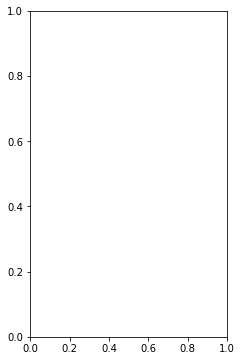

In [25]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define the directory containing the CSV files with correlation data
data_dir = 'analysis/motion'

# Initialize an empty list to store the separate DataFrames for each 'mri_movietask'
task_dfs = []

# Iterate through files in the data directory
for subject_name in os.listdir('analysis/roi_estimations'):
    if not subject_name.endswith('.csv'):
        continue
    
    # Extract the subject name from the activation data filename
    subject_name = subject_name.split('_')[0]
    
    # Initialize an empty DataFrame to store the combined data for the current subject
    combined_df = pd.DataFrame()
    
    # Loop through MRI movie tasks
    for mri_movietask in ['mri_movietask_1', 'mri_movietask_2', 'mri_movietask_3']:
        # Define paths to activation and motion data files
        activation_data_path = f'analysis/roi_estimations/{subject_name}_{mri_movietask}_smoothed_filtered_func_data_clean_MNI.nii.csv'
        motion_data_path = f'pulled-data-MRI/{subject_name}/{mri_movietask}/mc/prefiltered_func_data_mcf_rel.rms'
        
        # Check if both files exist before proceeding
        if os.path.exists(activation_data_path) and os.path.exists(motion_data_path):
            # Load activation and motion data into DataFrames
            activation_df = pd.read_csv(activation_data_path, header=0)  # Assuming header is in the first row
            motion_df = pd.read_csv(motion_data_path, header=None, names=['motion_parameter'])
            
            # Remove the first row (corresponding to the first time point) from activation data
            activation_df = activation_df.iloc[1:]
            
            # Ensure that the dimensions match (number of rows)
            if activation_df.shape[0] == motion_df.shape[0]:
                # Calculate the mean of activation data across regions
                activation_mean = activation_df.mean(axis=1)
                
                # Combine the activation and motion data into one DataFrame
                combined_df = pd.concat([combined_df, pd.concat([activation_mean, motion_df], axis=1)], axis=0)
            else:
                print(f"Dimensions of {activation_data_path} and {motion_data_path} do not match for {subject_name} and {mri_movietask}")
        else:
            print(f"Files not found for {subject_name} and {mri_movietask}")
    
    # Append the combined DataFrame for the current subject to the list
    task_dfs.append(combined_df)

# Create a list of 'mri_movietask' labels
mri_movietasks = ['mri_movietask_1', 'mri_movietask_2', 'mri_movietask_3']

# Create a separate violin plot for each 'mri_movietask'
plt.figure(figsize=(12, 6))
for i, mri_movietask in enumerate(mri_movietasks):
    plt.subplot(1, 3, i + 1)  # Create subplots for each task
    sns.violinplot(x='activation_mean', y='motion_parameter', data=task_dfs[i], split=True, inner="quart")
    plt.title(f'Violin Plot for {mri_movietask}')
    plt.xlabel('Activation (Mean)')
    plt.ylabel('Motion Parameter')

plt.tight_layout()

# Show the plots
plt.show()


## Regress out motion from ROI estimations using linear regression 

In [20]:
import os
import shutil
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Directory where ROI activation data is stored
activation_directory = 'analysis/roi_estimations'

# Directory to store motion-regressed ROI estimations
output_directory = 'analysis/roi_estimations/motion'

# Delete the output directory if it already exists (including all contents)
if os.path.exists(output_directory):
    shutil.rmtree(output_directory)

# Create the output directory
os.makedirs(output_directory)

# Loop through MRI movie tasks
for mri_movietask in ['mri_movietask_1', 'mri_movietask_2', 'mri_movietask_3']:
    # Get a list of all CSV files in the activation_directory
    csv_files = [file for file in os.listdir(activation_directory) if file.endswith('.csv')]

    # Loop through the CSV files
    for csv_file in csv_files:
        # Extract the subject name from the activation data filename
        subject_name = csv_file.split('_')[0]

        # Check if the subject name is valid for the current MRI movie task
        if os.path.exists(f'pulled-data-MRI/{subject_name}/{mri_movietask}'):
            # Define paths to activation and motion data files
            activation_data_path = os.path.join(activation_directory, csv_file)
            motion_data_path = f'pulled-data-MRI/{subject_name}/{mri_movietask}/mc/prefiltered_func_data_mcf.par'

            try:
                # Load ROI activation data with header row
                roi_activation_data = pd.read_csv(activation_data_path, header=0)
                # Read the motion data text file
                with open(motion_data_path, 'r') as file:
                    lines = file.readlines()
            except FileNotFoundError as e:
                # Handle the case where the file is not found for either motion or activation data
                if motion_data_path not in str(e):
                    print(f"Motion data file not found: {motion_data_path}")
                if activation_data_path not in str(e):
                    print(f"Activation data file not found: {activation_data_path}")

            # Split each line into a list of values and store them in a DataFrame
            motion_data = pd.DataFrame([line.split() for line in lines], dtype=float)

            # Check dimensions of both datasets
            if len(motion_data) != len(roi_activation_data):
                print(f"Length mismatch between ROI activation and motion data for {subject_name}")
                print(f"ROI activation data shape: {roi_activation_data.shape}")
                print(f"Motion data shape: {motion_data.shape}")
                continue  # Skip this subject and move to the next one

            # Convert lists to NumPy arrays with the appropriate data type (float)
            motion_data = np.array(motion_data, dtype=float)
            roi_activation_data = np.array(roi_activation_data, dtype=float)

            # Regress out all six motion parameters from ROI activation
            constant_term = np.ones((len(roi_activation_data), 1)) # intercept
            X = np.concatenate((constant_term, motion_data), axis=1)
            model = sm.OLS(roi_activation_data, X).fit() # sm.OLS(dependent, independent)
            residual_roi_activation = model.resid # This is the part of the ROI activation data that remains uncorrelated with the motion parameters after accounting for the linear relationship

            # Save the residual ROI activation to a new CSV file
            output_file = f'{subject_name}_{mri_movietask}_motion_regressed.csv'
            output_path = os.path.join(output_directory, output_file)
            pd.DataFrame(residual_roi_activation).to_csv(output_path, index=False)

Length mismatch between ROI activation and motion data for subject-0027
ROI activation data shape: (235, 300)
Motion data shape: (224, 6)
Length mismatch between ROI activation and motion data for subject-0060
ROI activation data shape: (235, 300)
Motion data shape: (242, 6)
Length mismatch between ROI activation and motion data for subject-0060
ROI activation data shape: (235, 300)
Motion data shape: (242, 6)
Length mismatch between ROI activation and motion data for subject-0112
ROI activation data shape: (235, 300)
Motion data shape: (233, 6)
Length mismatch between ROI activation and motion data for subject-0112
ROI activation data shape: (295, 300)
Motion data shape: (233, 6)
Length mismatch between ROI activation and motion data for subject-0163
ROI activation data shape: (235, 300)
Motion data shape: (39, 6)
Length mismatch between ROI activation and motion data for subject-0163
ROI activation data shape: (235, 300)
Motion data shape: (39, 6)
Length mismatch between ROI activati

#### There are some extra files in output directory because the above script still analyzed the subject sessions which were outliers in mean signal. See: excluded_data.csv

In [27]:
import os

activation_directory = 'analysis/roi_estimations'
output_directory = 'analysis/roi_estimations/motion'

def extract_prefix(filename):
    parts = filename.split('_')
    if len(parts) >= 4:
        return '_'.join(parts[:4])
    else:
        return filename

# Get a list of filenames in both directories
activation_files = os.listdir(activation_directory)
output_files = os.listdir(output_directory)

# Extract the prefixes from the filenames in both directories
activation_prefixes = set(map(extract_prefix, activation_files))
output_prefixes = set(map(extract_prefix, output_files))

# Find the prefixes that are in output_directory but not in activation_directory
output_only_prefixes = output_prefixes - activation_prefixes

# Display the differences
print("Prefixes in output_directory but not in activation_directory:")
for prefix in output_only_prefixes:
    print(prefix)

Prefixes in output_directory but not in activation_directory:
subject-0128_mri_movietask_3
subject-0203_mri_movietask_1
subject-0157_mri_movietask_1
subject-0128_mri_movietask_2
subject-0203_mri_movietask_2
subject-0158_mri_movietask_2
subject-0114_mri_movietask_3


##### Iterate through the output_directory and remove files with matching prefixes

In [28]:
for filename in os.listdir(output_directory):
    prefix = extract_prefix(filename)
    if prefix in output_only_prefixes:
        file_path = os.path.join(output_directory, filename)
        os.remove(file_path)
        print(f"Removed: {filename}")

print("File removal completed.")

Removed: subject-0157_mri_movietask_1_motion_regressed.csv
Removed: subject-0203_mri_movietask_1_motion_regressed.csv
Removed: subject-0128_mri_movietask_2_motion_regressed.csv
Removed: subject-0158_mri_movietask_2_motion_regressed.csv
Removed: subject-0203_mri_movietask_2_motion_regressed.csv
Removed: subject-0114_mri_movietask_3_motion_regressed.csv
Removed: subject-0128_mri_movietask_3_motion_regressed.csv
File removal completed.


### Next: Organize subject session data into each unique frame-topic combination